### Imports

In [1]:
import copy
import numpy as np
from image_utils import *
from PIL import Image

Retrieving the dataset from directory

In [2]:
training_dataset = np.genfromtxt('../dataset/training_dataset.csv', delimiter = ',')
validation_dataset = np.genfromtxt('../dataset/validation_dataset.csv', delimiter = ',')
print("Training dataset shape is {}".format(training_dataset.shape))
print("Validation dataset shape is {}".format(validation_dataset.shape))

Training dataset shape is (800, 12289)
Validation dataset shape is (200, 12289)


For convenience, we are going to organize the input features as colums, as we saw in previous notebook *Reshaping the matrix to a feature array* cell.
<br/>
We accomplish that calculating the **transpose** of both training dataset and validation dataset.

In [3]:
training_dataset = training_dataset.T
validation_dataset = validation_dataset.T

In [4]:
print("Training dataset shape is {}".format(training_dataset.shape))
print("Validation dataset shape is {}".format(validation_dataset.shape))

Training dataset shape is (12289, 800)
Validation dataset shape is (12289, 200)


As we have seen in **Dataset Creation** notebook, Each example in the  dataset is composed by 12.228 features (X) and 1 target value (y).

We are going to apply array slicing to divide our dataset accordingly.

In [5]:
total_size = 12289
features_size = 12288

X_training = training_dataset[0:features_size, :]
y_training = training_dataset[features_size:total_size, :]

X_validation = validation_dataset[0:features_size, :]
y_validation = validation_dataset[features_size:total_size, :]

print("Shape of X_training is {}".format(X_training.shape))
print("Shape of y_training is {}".format(y_training.shape))

print("Shape of X_validation is {}".format(X_validation.shape))
print("Shape of y_validation is {}".format(y_validation.shape))

Shape of X_training is (12288, 800)
Shape of y_training is (1, 800)
Shape of X_validation is (12288, 200)
Shape of y_validation is (1, 200)


Let's define the functions for our activation units:

### Sigmoid function 
Used in output layer

In [6]:
def sigmoid(x):
    """
    Compute the sigmoid of x

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(x)
    """
    s = 1 / (1 + np.exp(-x))
    return s

### Tanh function

Used in hidden layer

In [7]:
def tanh(x):
    """
    Compute the hyperbolic tangent of x

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    t -- tanh(x)
    """  
    t = (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x)) 
    return t

We are going to create a neural network with one hidden layer:

- Input layer: 12.288 nodes
- Hidden layer: 10 nodes
- Output layer: 1 node

As follows the useful functions tu build the neural network.

Recall the steps of the algorithm:

- Initialize parameters

- Repeat

    - Forward propagation
    
    - Compute cost
    
    - Backward propagation
    
    - Update parameters (weights and biases)

  Until it reaches total of epochs

In [8]:
def layer_sizes(X, hidden_units, Y):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    hidden_units -- number of hidden units
    Y -- labels of shape (output size, number of examples)
    
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    n_x = X.shape[0]
    n_h = hidden_units
    n_y = Y.shape[0]
    return (n_x, n_h, n_y)

In [9]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Arguments:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    parameters -- Python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    W1 = np.random.randn(n_h, n_x) * 0.01       # Shape (10, 12.228)
    b1 = np.zeros((n_h, 1))                     # Shape (10, 1)  
    W2 = np.random.randn(n_y, n_h) * 0.01       # Shape (1, 10)
    b2 = np.zeros((n_y, 1))                     # Shape (1, 1)
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [10]:
def forward_propagation(X, parameters):
    """
    Arguments:
    X -- input data of size (n_x, m)
    parameters -- Python dictionary containing your parameters (output of initialize_parameters function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a Python dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    Z1 = np.dot(W1, X) + b1 
    A1 = tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
        
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [11]:
def compute_cost(A2, Y):
    """    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)

    Returns:
    cost -- cross-entropy equation
    
    """
    
    m = Y.shape[1] # number of examples

    logprobs = np.multiply(np.log(A2), Y) + np.multiply((1 - Y), np.log(1 - A2))
    cost = - np.sum(logprobs) / m
    
    cost = float(np.squeeze(cost))  # makes sure cost is the dimension we expect. E.g., turns [[20]] into 20 
    
    return cost

In [12]:
def backward_propagation(parameters, cache, X, Y):
    """    
    Arguments:
    parameters -- Python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (number of input features, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- Python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]
    
    W1 = parameters['W1']
    W2 = parameters['W2']
    A1 = cache['A1']
    A2 = cache['A2']
    
    #Derivatives
    dZ2= A2 - Y
    dW2 = (1 / m) * np.dot(dZ2, A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.multiply(np.dot(W2.T, dZ2), 1 - np.power(A1, 2))
    dW1 = (1 / m) * np.dot(dZ1, X.T)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

In [13]:
def update_parameters(parameters, grads, learning_rate = 0.01):
    """
    Updates parameters using the gradient descent update rule
    
    Arguments:
    parameters -- Python dictionary containing your parameters 
    grads -- Python dictionary containing your gradients
    learning_rate -- tuning parameter in an optimization algorithm that determines the step size at each iteration while moving towards a minimum of a loss function.
    
    Returns:
    parameters -- Python dictionary containing your updated parameters 
    """
    W1 = copy.deepcopy(parameters['W1'])
    b1 = parameters['b1']
    W2 = copy.deepcopy(parameters['W2'])
    b2 = parameters['b2']

    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']
    
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [14]:
def neural_network_model(X, y, hidden_units, num_iterations = 10000, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (number of input features, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 100 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can be used to predict.
    """
    
    np.random.seed(3)
    n_x = layer_sizes(X, hidden_units, y)[0]
    n_h = layer_sizes(X, hidden_units, y)[1]
    n_y = layer_sizes(X, hidden_units, y)[2]
    
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    # Loop (gradient descent)
    for i in range(1, num_iterations + 1):
         
        A2, cache = forward_propagation(X, parameters)
        cost = compute_cost(A2, y)
        grads = backward_propagation(parameters, cache, X, y)
        parameters = update_parameters(parameters, grads)
        
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

In [15]:
parameters = neural_network_model(X_training, y_training, hidden_units = 10, num_iterations = 2000, print_cost = True)

Cost after iteration 100: 0.687402
Cost after iteration 200: 0.621263
Cost after iteration 300: 0.482105
Cost after iteration 400: 0.388211
Cost after iteration 500: 0.346529
Cost after iteration 600: 0.286619
Cost after iteration 700: 0.230307
Cost after iteration 800: 0.158990
Cost after iteration 900: 0.314876
Cost after iteration 1000: 0.129822
Cost after iteration 1100: 0.142129
Cost after iteration 1200: 0.083406
Cost after iteration 1300: 0.073552
Cost after iteration 1400: 0.062444
Cost after iteration 1500: 0.054124
Cost after iteration 1600: 0.047416
Cost after iteration 1700: 0.041924
Cost after iteration 1800: 0.037375
Cost after iteration 1900: 0.033574
Cost after iteration 2000: 0.030370


In [16]:
 def accuracy(X, y):
        
        examples = X.shape[1]
        A2, cache = forward_propagation(X, parameters)
        predictions = np.squeeze((A2 > 0.5).astype(int))
        y = np.squeeze(y)
        
        # Calculate accuracy
        assertions = 0
        for i in range(examples):
            if predictions[i] == int(y[i]):
                assertions += 1
        
        return assertions / examples

Clearly we do not get a high accuracy for our trained model. You might wonder what is the reason: I will treat this argument in another opportunity.

In [17]:
print("Accuracy for validation dataset is {}".format(accuracy(X_validation ,y_validation)))

Accuracy for validation dataset is 0.825


### Prediction on new images

A horse image


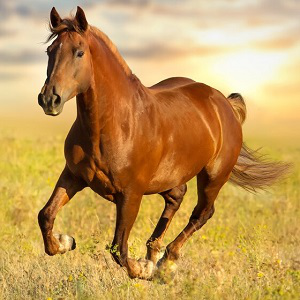

In [18]:
red_horse_image_path = '../dataset/other/red_horse.png'
red_horse_image = show_image(red_horse_image_path)
print("A horse image")
red_horse_image

A human image


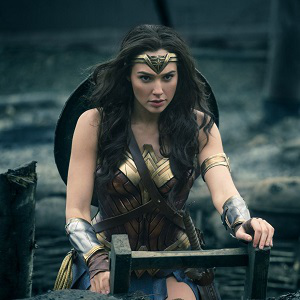

In [19]:
wonder_woman_image_path = '../dataset/other/wonder_woman.png'
wonder_woman_image = show_image(wonder_woman_image_path)
print("A human image")
wonder_woman_image

A horse image


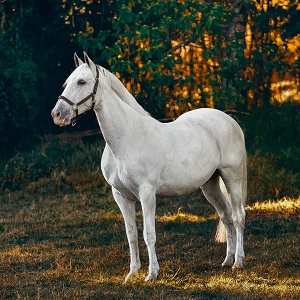

In [20]:
white_horse_image_path = '../dataset/other/white_horse.png'
white_horse_image = show_image(white_horse_image_path)
print("A horse image")
white_horse_image

In [21]:
def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- Python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (human: 0 / horse: 1)
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    A2, cache = forward_propagation(X, parameters)
    prediction = np.squeeze((A2 > 0.5).astype(int))
    
    if prediction == 1:
        print("It's a horse")
    else:
        print("It's a human")

### Example 1 (correct prediction)

In [22]:
img_matrix_1 = reshape_matrix(red_horse_image_path)
predict(parameters, img_matrix_1)

It's a horse


### Example 2 (correct prediction)

In [23]:
img_matrix_2 = reshape_matrix(wonder_woman_image_path)
predict(parameters, img_matrix_2)

It's a human


### Example 3 (wrong prediction)

In [24]:
img_matrix_3 = reshape_matrix(white_horse_image_path)
predict(parameters, img_matrix_3)

It's a human


### What we usually do in TensorFlow

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense

In [26]:
# Function that returns the model architecture
def create_model(input_features):
    
    # Create an instance of Sequential class
    model = Sequential()
    
    # Add layers
    model.add(Dense(10, input_dim = input_features, activation = 'tanh')) 
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])
    
    return model

In [27]:
# TensorFlow requires the dataset as follows, so we traspose the arrays:
# X: samples x features
# y: samples x target value

X_training = X_training.T
y_training = y_training.T
X_validation = X_validation.T
y_validation = y_validation.T

print(X_training.shape)
print(y_training.shape)
print(X_validation.shape)
print(y_validation.shape)

(800, 12288)
(800, 1)
(200, 12288)
(200, 1)


In [28]:
# Instance the model architecture
model = create_model(features_size)
# Train the model
model.fit(X_training, y_training, epochs = 2000, verbose = 0)

In [29]:
model.evaluate(X_validation, y_validation)

7/7 [==============================] - 0s 2ms/step - loss: 1.1849 - accuracy: 0.7850


[1.1848708391189575, 0.7850000262260437]

In our examples used to predict in previous cells, their features are organized as columns. 

In [30]:
print("Shape of img_matrix_1: {}".format(img_matrix_1.shape))
print("Shape of img_matrix_2: {}".format(img_matrix_2.shape))
print("Shape of img_matrix_3: {}".format(img_matrix_3.shape))

Shape of img_matrix_1: (12288, 1)
Shape of img_matrix_2: (12288, 1)
Shape of img_matrix_3: (12288, 1)


Recall that TensorFlow requires features organized as rows, so once again we transpose the arrays.

In [31]:
img_matrix_1 = img_matrix_1.T
img_matrix_2 = img_matrix_2.T
img_matrix_3 = img_matrix_3.T

In [32]:
print("Shape of img_matrix_1: {}".format(img_matrix_1.shape))
print("Shape of img_matrix_2: {}".format(img_matrix_2.shape))
print("Shape of img_matrix_3: {}".format(img_matrix_3.shape))

Shape of img_matrix_1: (1, 12288)
Shape of img_matrix_2: (1, 12288)
Shape of img_matrix_3: (1, 12288)


Prediction on new samples

In [33]:
def predict_sample(model, sample):
    prediction = np.squeeze(model.predict(sample)) > 0.5
    if prediction == 1:
        print("It's a horse")
    else:
        print("It's a human")

In [34]:
predict_sample(model, img_matrix_1)
predict_sample(model, img_matrix_2)
predict_sample(model, img_matrix_3)

It's a horse
It's a human
It's a human
